<a href="https://colab.research.google.com/github/adrianoracano/Prog-NAPDE/blob/main/prova_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [ ]:
!git clone https://github.com/adrianoracano/Prog-NAPDE.git

fatal: destination path 'Prog-NAPDE' already exists and is not an empty directory.


In [ ]:
%cd /gdrive/My Drive/Prog-NAPDE/Prog-NAPDE

/gdrive/My Drive/Prog-NAPDE/Prog-NAPDE


In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt
import os
import random
import MyDatasetGenerator as dg

tfk = tf.keras
tfkl = tf.keras.layers
tf.keras.backend.set_floatx('float64')

np.random.seed(123)
tf.random.set_seed(123)

## ODE-NN


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
# initial condition
f0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
# Create model
def multilayer_perceptron(x):
    x = np.array([[[x]]],  dtype='float32')
    # Hidden fully connected layer with 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    output = tf.matmul(layer_2, weights['out']) + biases['out']
    return output

# Universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

# Given EDO
def f(x):
    return 2*x
    
# Custom loss function to approximate the derivatives
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

In [ ]:
multilayer_perceptron(1)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[-3.383441]]], dtype=float32)>

In [ ]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 4216.851074 
loss: 4.348598 
loss: 4.212492 
loss: 4.128182 
loss: 4.046163 
loss: 3.928887 
loss: 3.629016 
loss: 1.611184 
loss: 0.089094 
loss: 0.018557 


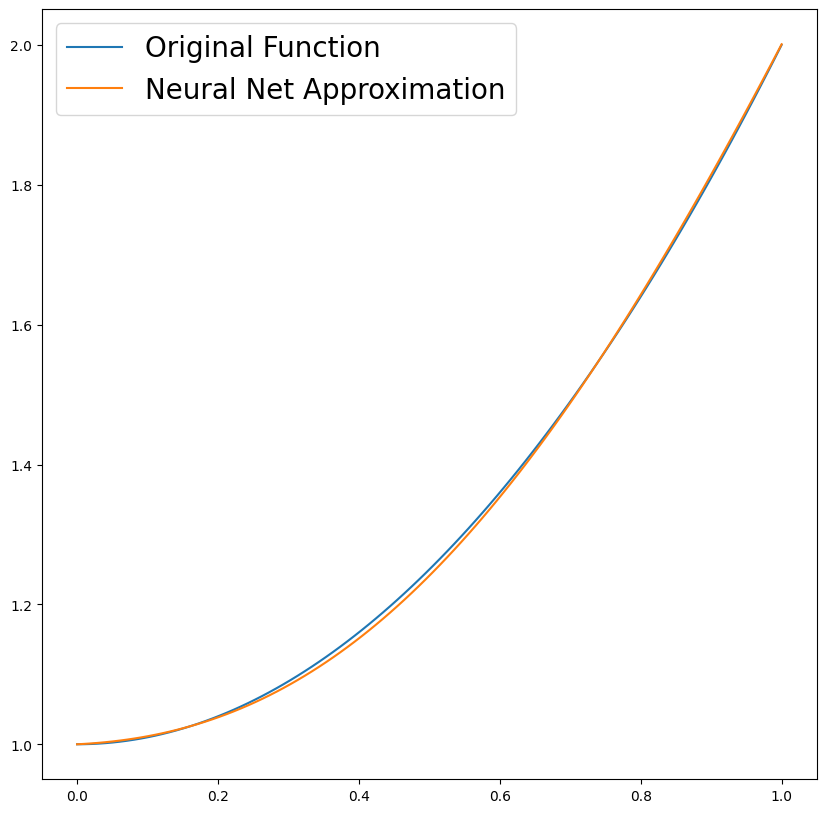

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

##Ode ffnn



In [ ]:
!reset

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [ ]:
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10
inf_s = np.sqrt(np.finfo(np.float32).eps)
f0 = 1

In [ ]:
# Build the neural network layer by layer
input_layer = tfkl.Input(shape=(1), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

In [ ]:
y = np.array([[1]])
model(y).numpy()[0][0]

0.041242518

In [ ]:
optimizer = tfk.optimizers.SGD(learning_rate=1e-2)

In [ ]:
# Universal Approximator
def f(x):
    return x**2 + 1

def g(x):
    return x * model(np.array([x])) + f0
    
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 2.097122 
loss: 0.063623 
loss: 0.062680 
loss: 0.058569 
loss: 0.048885 
loss: 0.041855 
loss: 0.042228 
loss: 0.048908 
loss: 0.054025 
loss: 0.044953 


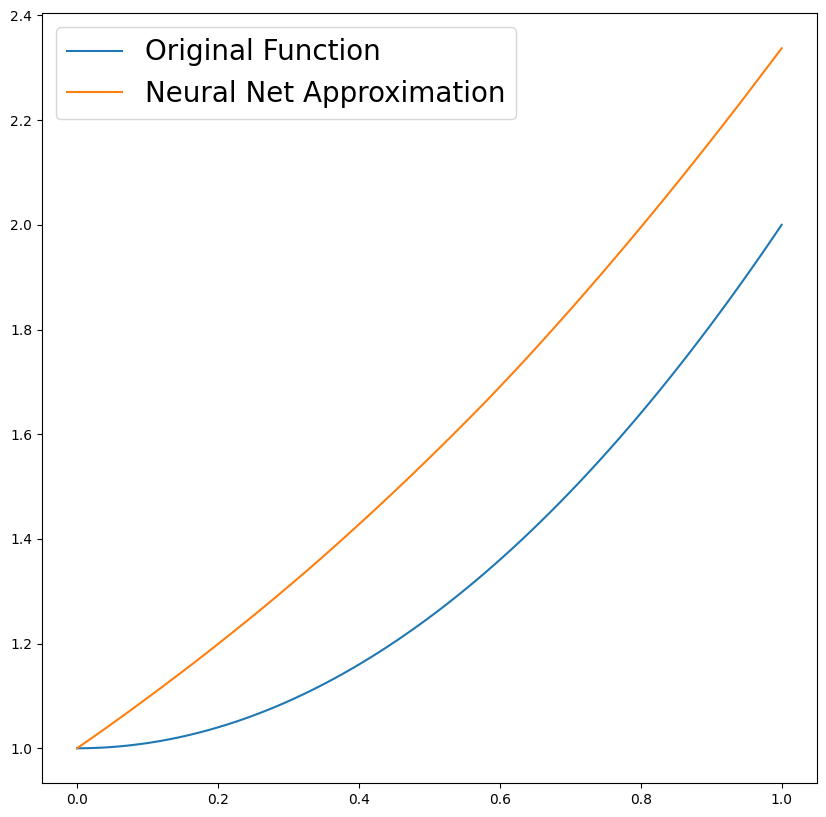

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

##ffnn nostro problema

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [ ]:
input_layer = tfkl.Input(shape=(2), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model2 = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN2')

In [ ]:
optimizer = tfk.optimizers.SGD(learning_rate=1e-2)

In [ ]:
x = np.array([[1,2]])
model2(x)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.20769306]], dtype=float32)>

In [ ]:
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

In [ ]:
tau = 365
def g2(beta, T):
    x = np.array([[beta, T]])
    #return x * multilayer_perceptron(x)
    return model2(x)
def beta_eq(T):
    return (35 - T)/T
def T(t):
    return math.exp(-(t - 180)**2/(2*80**2))/(math.sqrt(2*math.pi)*80)*300*5*2.6 + 5 
def dbeta(beta, t):
    return 1/tau*(beta_eq(T(t)) - beta[0])
def dbeta_hat(beta, t):
    return g(beta[0], T(t))

sys = [dbeta]    

t_max=365.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N

In [ ]:
beta.shape
beta[0][30]

0.6997887005569842

In [ ]:
g2(1,2) + 1


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.79230696]], dtype=float32)>

In [ ]:
def custom_loss2():
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)-1):
        next_beta = curr_beta + dt * g2(curr_beta,T(i*dt))
        summation.append((beta[0][i+1] - next_beta)**2 )
        curr_beta = next_beta.numpy()[0][0]
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step2():
    with tf.GradientTape() as tape:
        loss = custom_loss2()
    gradients = tape.gradient(loss, model2.trainable_variables)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))

In [ ]:
curr_beta = beta0[0]
next_beta = curr_beta
next_beta = curr_beta + dt * g2(curr_beta,T(1*dt))
next_beta
(beta[0][1] - next_beta)**2

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7952166]], dtype=float32)>

In [ ]:
for i in range(training_steps):
  train_step2()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss2()))

[None, None, None, None, None, None]


ValueError: ignored

NameError: ignored

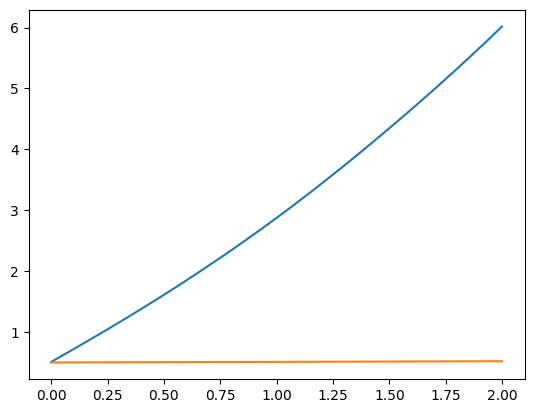

In [ ]:
summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g2(curr_beta, T(dt*i)).numpy()[0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")

In [ ]:
for i in range(len(t)):
  print(beta_hat[i])

0.508415189743042
0.5168356695175171
0.5252614030838013
0.5336923961639405
0.5421286487579347
0.5505701665878296
0.5590169515609742
0.5674690074920655
0.5759263381958009
0.5843889436721803
0.5928568325042726
0.6013300037384034
0.6098084611892701
0.61829220867157
0.6267812500000002
0.6352755870819093
0.6437752218246462
0.6522802610397341
0.6607907190322878
0.6693065996170046
0.6778279056549074
0.6863546409606935
0.694886808395386
0.7034244117736819
0.71196745300293
0.7205159368515017
0.7290698680877689
0.7376292486190799
0.7461940803527835
0.7547643680572512
0.7633401136398318
0.7719213228225711
0.7805079975128176
0.7891001424789431
0.7976977596282961
0.8063008518218997
0.8149094238281253
0.8235234775543215
0.8321430177688601
0.8407680473327639
0.8493985691070559
0.858034588813782
0.8666761064529422
0.8753231287002567
0.8839760351181034
0.8926359052658085
0.9013027458190922
0.9099765625000004
0.9186573610305789
0.9273451461791995
0.9360399246215824
0.944741701126099
0.9534504814147953
0

##prova beta


In [ ]:
!reset

loss: 13.332240 
loss: 11.879288 
loss: 10.485337 
loss: 9.151624 
loss: 7.880266 
loss: 6.678349 
loss: 5.560703 
loss: 4.544685 
loss: 3.639080 
loss: 2.838927 
loss: 2.132170 
loss: 1.514741 
loss: 1.014345 
loss: 0.711639 
loss: 0.614201 
loss: 0.590291 
loss: 0.579011 
loss: 0.569955 
loss: 0.561395 
loss: 0.552963 
loss: 0.544565 
loss: 0.536178 
loss: 0.527795 
loss: 0.519415 
loss: 0.511038 
loss: 0.502664 
loss: 0.494291 
loss: 0.485922 
loss: 0.477554 
loss: 0.469189 
loss: 0.460826 
loss: 0.452465 
loss: 0.444106 
loss: 0.435750 
loss: 0.427395 
loss: 0.419043 
loss: 0.410692 
loss: 0.402343 
loss: 0.393996 
loss: 0.385651 
loss: 0.377307 
loss: 0.368965 
loss: 0.360624 
loss: 0.352285 
loss: 0.343947 
loss: 0.335610 
loss: 0.327274 
loss: 0.318940 
loss: 0.310606 
loss: 0.302273 
loss: 0.293942 
loss: 0.285611 
loss: 0.277282 
loss: 0.268954 
loss: 0.260627 
loss: 0.252303 
loss: 0.243980 
loss: 0.235661 
loss: 0.227345 
loss: 0.219034 
loss: 0.210728 
loss: 0.202429 
loss:

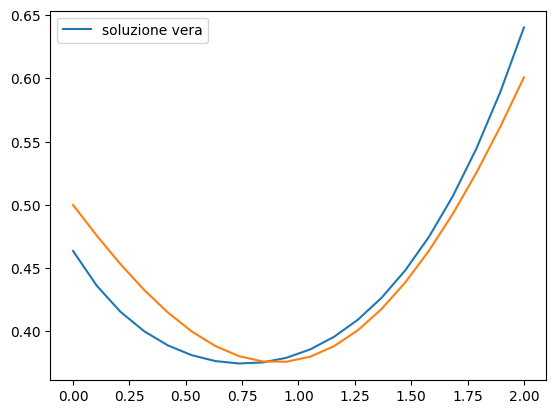

In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt

f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 5
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta, T):
    x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(x)
# Given EDO
tau = 2.

def beta_eq(T):
    return 1.0 - T

def T(t):
    return math.cos(t)

def dbeta(beta, t):
    return 1/tau*( beta_eq(T(t)) - beta[0] )
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=tau
N=20
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N


def custom_loss():
    
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(beta.shape[1]-1):
        x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * multilayer_perceptron( x )
        summation.append( (beta[0,i+1] - next_beta)**2 )
        curr_beta = next_beta.numpy()[0][0][0][0]
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions(["soluzione vera"])

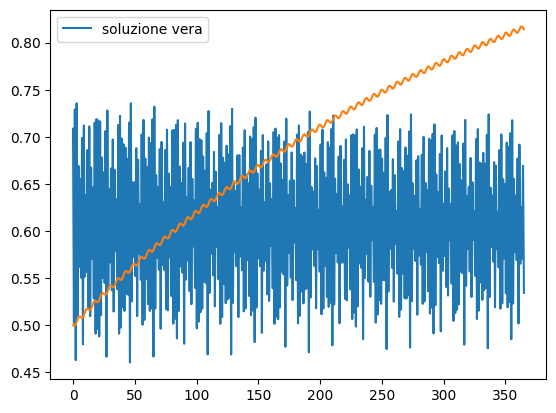

In [ ]:
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions(["soluzione vera"])

## Prova

loss: 0.054779 
loss: 0.053413 
loss: 0.052066 
loss: 0.050739 
loss: 0.049431 


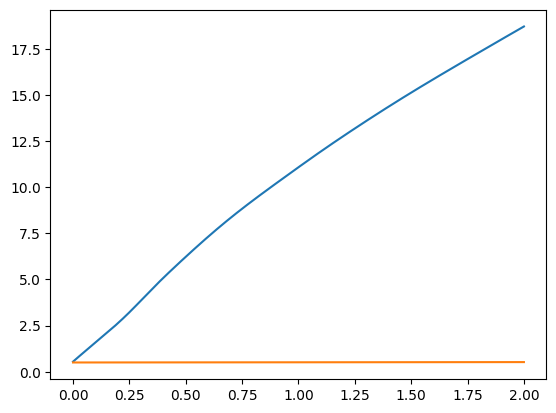

In [ ]:
f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 50
batch_size = 100
display_step = 10
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta, T):
    x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(x)
# Given EDO
tau = 365.

def beta_eq(T):
    return (35 - T)/T
def T(t):
    return math.exp(-(t - 180)**2/(2*80**2))/(math.sqrt(2*math.pi)*80)*300*5*2.6 + 5 
def dbeta(beta, t):
    return 1/tau*(beta_eq(T(t)) - beta[0])
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=2.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N

def custom_loss():
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)):
        x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * multilayer_perceptron( x )
        summation.append( dt*(beta[i] - next_beta)**2 )
        curr_beta = next_beta
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")


In [ ]:
for i in range(len(t)):
  print(beta_hat[i] - )

0.4825128479003906
0.4651818313598633
0.4480051326751709
0.430980899810791
0.4141072311401367
0.3973822078704834
0.38080386734008786
0.36437023735046387
0.3480793170928955
0.33192909240722657
0.3159175395965576
0.3000426187515259
0.2843022880554199
0.2686945009231567
0.2532172117233276
0.23786837673187253
0.22264595508575435
0.2075479173660278
0.19257223510742183
0.17771689987182612
0.16297991180419916
0.1483592853546142
0.1338530597686767
0.11945928096771234
0.105176022529602
0.09100137138366693
0.07693344402313226
0.06297037792205805
0.049110332489013614
0.035351491928100526
0.021692068099975526
0.008130294799804627
-0.005335564613342347
-0.018707216262817447
-0.03198635101318366
-0.045174619674682684
-0.058273648262024
-0.07128503608703621
-0.08421035671234138
-0.09705115127563484
-0.10980893421173103
-0.12248519325256355
-0.13508138465881356
-0.14759894275665292
-0.1600392656326295
-0.17240372848510752
-0.18469368076324472
-0.19691043949127207
-0.20905530071258555
-0.22112953186035

##prova model


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [ ]:
input_layer = tfkl.Input(shape=(2), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model2 = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN2')

In [ ]:
optimizer = tfk.optimizers.SGD(learning_rate=1e-2)

In [ ]:
with GradientTape() as tape
  y = model(x)
  dmodeldx = tape.gradient(y,x)

##Prova con g

In [ ]:
!reset

In [ ]:

import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt

# Network Parameters
# initial condition
beta0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 100
batch_size = 100
display_step = 1

# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
    x = np.array([[[x]]],  dtype='float32')
    # Hidden fully connected layer with 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    output = tf.matmul(layer_2, weights['out']) + biases['out']
    return output
# Universal Approximator
def g(t):
    #return x * multilayer_perceptron(x)
    return t * multilayer_perceptron(t) + beta0
# Given EDO
tau = 365.

def beta_eq(T):
    return 1.0 - T

def T(t):
    return math.cos(t)

def dbeta(beta, t):
    return 1/tau*( beta_eq(T(t)) - beta[0] )
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(t,beta):
  return 1/tau*(beta_eq(T(t)) - beta)
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=365.0
N=100
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N




In [ ]:
def custom_loss():
    summation = []
    for i in range(beta.shape[1]):
        dNN = (g(i*dt+inf_s)-g(i*dt))/inf_s
        summation.append((dNN - f(i*dt,beta[0][i]))**2)
    return tf.reduce_sum(tf.abs(summation))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

In [ ]:
def train_step_t():
    with tf.GradientTape(persistent=True) as tape:
        summation = []
        for x in range(len(t)):
            i = x 
            x = tf.constant([[[x]]],  dtype='float32')
            tape.watch(x)
            g_x = x * multilayer_perceptron(x) + f0
            dNN = tape.gradient(g_x, x)
            summation.append(dNN - f(i,beta[0][i]))
        loss = tf.reduce_sum(tf.abs(summation))
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

for i in range(training_steps):
    train_step_t()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 16226.163086 
loss: 9.227602 
loss: 7485.161621 
loss: 10.367116 
loss: 4506.379395 
loss: 17.406197 
loss: 2969.949219 
loss: 9.738179 
loss: 1955.538208 
loss: 13.464764 
loss: 1410.222656 
loss: 16.515778 
loss: 1339.480713 
loss: 18.977001 
loss: 1295.891968 
loss: 22.621662 
loss: 1257.162231 
loss: 27.501942 
loss: 1201.199463 
loss: 34.337982 
loss: 1128.456055 
loss: 43.862000 
loss: 1045.650635 
loss: 58.542904 
loss: 912.455750 
loss: 79.655502 
loss: 664.987671 
loss: 94.061058 
loss: 446.211029 
loss: 93.638977 
loss: 442.846985 
loss: 93.819199 
loss: 441.796967 
loss: 94.224396 
loss: 438.357605 
loss: 93.223366 
loss: 437.004089 
loss: 93.117828 
loss: 433.165558 
loss: 92.959404 
loss: 428.415771 
loss: 93.511932 
loss: 436.150543 
loss: 92.761810 
loss: 435.484924 
loss: 93.556068 
loss: 436.273682 
loss: 93.007942 
loss: 434.454590 
loss: 93.842636 
loss: 434.071594 
loss: 92.942383 
loss: 433.245483 
loss: 92.885422 
loss: 433.405182 
loss: 93.656059 
loss: 434

KeyboardInterrupt: ignored

In [ ]:
multilayer_perceptron(1)

InvalidArgumentError: ignored

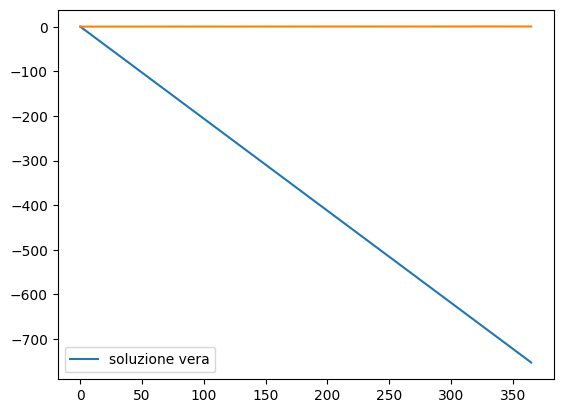

In [ ]:
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    beta_hat[i] = g(dt*i).numpy()[0][0][0]
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions(["soluzione vera"])

##Prova codice di ale

In [ ]:
!reset

In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt
import os
import random
import MyDatasetGenerator as dg

tfk = tf.keras
tfkl = tf.keras.layers
tf.keras.backend.set_floatx('float64')

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 100
batch_size = 100
display_step = 1
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

initializer = tf.keras.initializers.GlorotNormal(seed = seed)

weights = {
'h1': tf.Variable(initializer(shape = (n_input, n_hidden_1))),
'h2': tf.Variable(initializer(shape = (n_hidden_1, n_hidden_2))),
'out': tf.Variable(initializer(shape = (n_hidden_2, n_output)))
}
biases = {
'b1': tf.Variable(initializer(shape = (n_hidden_1,))),
'b2': tf.Variable(initializer(shape = (n_hidden_2,))),
'out': tf.Variable(initializer(shape = (n_output,)))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  #x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  #layer_1 = tf.nn.leaky_relu(layer_1)
  layer_1 = tf.nn.tanh(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  #layer_2 = tf.nn.leaky_relu(layer_2)
  layer_2 = tf.nn.tanh(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator


In [ ]:
model = tfk.Sequential([
    tfk.layers.Dense(50, activation='tanh', input_shape=(2,)),
    tfk.layers.Dense(50, activation='tanh'),
    tfk.layers.Dense(1),
#    tfk.layers.Softmax()
])
x = tf.constant([[1,2]])
model(x)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.22875319]])>

In [ ]:
def g(beta, T):
    T = tf.expand_dims(T,-1)
    T = tf.expand_dims(T,-1)  
    x = tf.concat([beta,T],-1)
    #return x * multilayer_perceptron(x)
    return model(x)
# Given EDO
tau =365

def beta_eq(T):
    return 0.8 - (0.6/35)*T
"""
def T(t):
    return -t**2+5*t
"""

# QUI VENGONO GENERATE DELLE TEMPERATURE
temperature_funcs = []
K = 5 # numero di funzioni temperatura
for k in range(K):
    center = random.gauss(120.0, 5.0)
    height = random.gauss(16.0, 2.0)
    width = random.gauss(14.0, 1.0)
    def T(t):
        return math.sin(2*math.pi/tau*(t-center))*width + height
    temperature_funcs.append(T)
     

# QUI VIENE DEFINITO IL SISTEMA: dbeta = f(beta(t), T(t))

N = 100
t_max = 365.
beta0 = np.array([0.1])
def f(beta, T):
    return (beta_eq(T) - beta[0])/tau

data = {
    "N" : N,
    "t_max" : t_max,
    "beta0" : beta0,
    "f" : f
}

dataset = dg.generate_dataset(temperature_funcs, data)
dataset = tf.convert_to_tensor(dataset)
dataset = dataset

# UNA NUOVA CUSTOM_LOSS CHE UTILIZZA TUTTE LE TEMPERATURE
dt = t_max / N
summation_step = 5
def custom_loss():
    summation = []
    for k in range(K):
        curr_beta = tf.constant([[beta0[0]]])
        next_beta = curr_beta
        for i in range(N-1):
            next_beta = curr_beta + dt/365 * g(curr_beta, dataset[0, k, i]/365)
            if i % summation_step == 0:
                summation.append((dataset[1, k, i+1] - next_beta)**2)
            curr_beta = next_beta
    return tf.sqrt(tf.reduce_mean(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    #trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
# Training the Model:


In [ ]:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("iterazione numero: %i " %(i))
    print("loss: %f " % (custom_loss()))

"""
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i+1] = next_beta
    curr_beta = next_beta
"""

# ORA GENERO UNA NUOVA TEMPERATURA DIFFERENTE DALLE PRECEDENTI E FACCIO UN PLOT

center = random.gauss(120.0, 5.0)
height = random.gauss(16.0, 2.0)
width = random.gauss(14.0, 1.0)
def T(t):
    return math.sin(2*math.pi/tau*(t-center))*width + height



def dbeta(beta, t):
    return f(beta, T(t))
sys = [dbeta]
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
curr_beta = tf.constant([[beta0[0]]])
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    next_beta = curr_beta + dt/365 * g( curr_beta, T(dt*i*365)/365 )
    beta_hat[i+1] = next_beta[0][0]
    curr_beta = next_beta

pp = plt.plot(t, beta_hat)
plt.plot(t, beta[0, ])
plt.legend(["soluzione rete", "solzione vera"])

iterazione numero: 0 
loss: 0.148145 
iterazione numero: 1 
loss: 0.135288 
iterazione numero: 2 
loss: 0.122577 
iterazione numero: 3 
loss: 0.110084 
iterazione numero: 4 
loss: 0.097912 
iterazione numero: 5 
loss: 0.086220 
iterazione numero: 6 
loss: 0.075241 
iterazione numero: 7 
loss: 0.065307 
iterazione numero: 8 
loss: 0.056847 
iterazione numero: 9 
loss: 0.050298 
iterazione numero: 10 
loss: 0.045871 
iterazione numero: 11 
loss: 0.043327 
iterazione numero: 12 
loss: 0.042068 
iterazione numero: 13 
loss: 0.041505 
iterazione numero: 14 
loss: 0.041264 
iterazione numero: 15 
loss: 0.041158 
iterazione numero: 16 
loss: 0.041107 
iterazione numero: 17 
loss: 0.041078 
iterazione numero: 18 
loss: 0.041058 
iterazione numero: 19 
loss: 0.041041 
iterazione numero: 20 
loss: 0.041026 
iterazione numero: 21 


KeyboardInterrupt: ignored

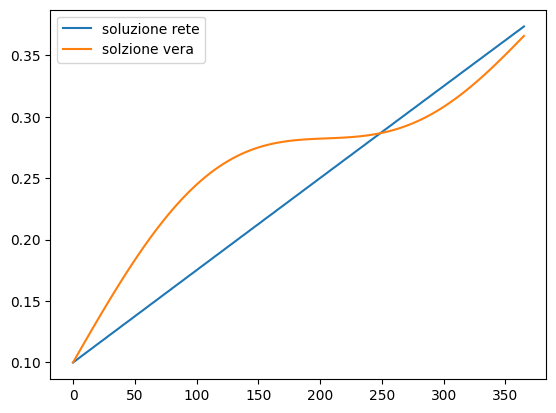

In [ ]:

# ORA GENERO UNA NUOVA TEMPERATURA DIFFERENTE DALLE PRECEDENTI E FACCIO UN PLOT

center = random.gauss(120.0, 5.0)
height = random.gauss(16.0, 2.0)
width = random.gauss(14.0, 1.0)
def T(t):
    return tf.constant(math.sin(2*math.pi/tau*(t-center))*width + height, dtype = 'float64')



def dbeta(beta, t):
    return f(beta, T(t))
sys = [dbeta]
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
curr_beta = tf.constant([[beta0[0]]], dtype = 'float64')
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    next_beta = curr_beta + dt/365 * g( curr_beta, T(dt*i*365)/365 )
    beta_hat[i+1] = next_beta[0][0]
    curr_beta = next_beta

pp = plt.plot(t, beta_hat)
plt.plot(t, beta[0, ])
plt.legend(["soluzione rete", "soluzione vera"])

In [ ]:
center = random.gauss(120.0, 5.0)
height = random.gauss(16.0, 2.0)
width = random.gauss(14.0, 1.0)
def T(t):
    return math.sin(2*math.pi/t_max*(t-center))*width + height



def dbeta(beta, t):
    return f(beta, T(t))
sys = [dbeta]
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
curr_beta = tf.constant([[beta0[0]]], dtype = 'float64')
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    next_beta = curr_beta + dt/365 * g( curr_beta, T(dt*i*365)/365 )
    beta_hat[i+1] = next_beta[0][0]
    curr_beta = next_beta

pp = plt.plot(t, beta_hat)
plt.plot(t, beta[0, ])
plt.legend(["soluzione rete", "solzione vera"])

InvalidArgumentError: ignored

##prova senza temperatura

In [ ]:
!reset

In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt
tf.keras.backend.set_floatx('float32')

f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 200
batch_size = 100
display_step = 1
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  # x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta):
    # x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(beta)
# Given EDO
tau = 365.

def beta_eq(T):
    return 25.0 - T

def T(t):
    return math.cos(t)

def dbeta(beta, t):
    return  beta[0] - 10.0
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=3.0
N=250
beta0=np.array([1.0])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N


def custom_loss():
    curr_beta = tf.constant([[beta0[0]]], dtype = 'float32')
    #next_beta = curr_beta
    summation = []
    for i in range(beta.shape[1]-1):
        # x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * g( curr_beta )
        #next_beta = curr_beta + dt * g(curr_beta)
        summation.append( (beta[0, i+1] - next_beta)**2 )
        curr_beta = next_beta
    return tf.reduce_mean(summation)
"""
def f_prova(x):
    return x**2

def custom_loss2():
    x = np.linspace(-1.0, 1.0, 100)
    summation = []
    for i in range(len(x)):
        summation.append( ( f_prova(x[i]) - g(x[i]) )**2 )
    return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))


curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta )
    beta_hat[i+1] = next_beta.numpy()[0][0]
    curr_beta = next_beta
    
    
plt.plot(t, beta_hat)
cn_solver.plot_solutions()

loss: 465.929413 
loss: 447.803833 
loss: 445.344238 
loss: 444.826569 
loss: 444.531677 
loss: 444.276093 


KeyboardInterrupt: ignored

In [ ]:
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
beta_hat[0]=curr_beta
for i in range(beta.shape[1]-1):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta )
    beta_hat[i+1] = next_beta.numpy()[0][0]
    curr_beta = next_beta
    
    
plt.plot(t, beta_hat)
cn_solver.plot_solutions()

InvalidArgumentError: ignored

#prova a caso


In [ ]:
!reset

In [ ]:
tf.keras.layers.experimental.preprocessing.Normalization(dtype='float64')
model = tfk.Sequential([
    tfk.layers.Dense(20, activation='relu', input_shape=(1,)),
#    tfk.layers.Dense(20, activation='relu'),
    tfk.layers.Dense(1, activation='relu'),
#    tfk.layers.Softmax()
])


In [ ]:
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

N = 10
training_steps = 100
display_step = 1
def f1(x):
  return math.exp(-x)
summation = []
dt = 10/N
def loss1():
  y0 =  tf.constant([[f1(0)]], dtype = 'float64')
  for i in range(N-1):
    i = i + 1
    y = y0 + dt*i * model([[y0]])
    summation.append((f1(dt*i) - y)**2)
    y0 = y
  return tf.reduce_mean(tf.abs(summation))
def train_step2():
  with tf.GradientTape() as tape:
    loss = loss1()
  gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return gradients
for i in range(training_steps):
  train_step2()
  if i % display_step == 0:
    print("iterazione numero: %i " %(i))
    print("loss: %f " % (loss1()))

y = tf.zeros(shape = (1,N), dtype = 'float64')
y0 =  tf.constant([[f1(0)]], dtype = 'float64')
y[0,0] = y0
yex = y
for i in range(N-1):
  y[0,i+1] = y[0,1] + dt*i*model(y[0,i])
  yex[0,i+1] = f1(dt*i)

t = np.linspace(start = 0, stop = 10, num = N)

plt.plot(t,y[0])
plt.plot(t,yex[0])


iterazione numero: 0 
loss: 0.888079 
iterazione numero: 1 
loss: 0.888079 
iterazione numero: 2 
loss: 0.888079 
iterazione numero: 3 
loss: 0.888079 
iterazione numero: 4 
loss: 0.888079 
iterazione numero: 5 
loss: 0.888079 
iterazione numero: 6 
loss: 0.888079 
iterazione numero: 7 
loss: 0.888079 
iterazione numero: 8 
loss: 0.888079 
iterazione numero: 9 
loss: 0.888079 
iterazione numero: 10 
loss: 0.888079 
iterazione numero: 11 
loss: 0.888079 
iterazione numero: 12 
loss: 0.888079 
iterazione numero: 13 
loss: 0.888079 
iterazione numero: 14 
loss: 0.888079 
iterazione numero: 15 
loss: 0.888079 
iterazione numero: 16 
loss: 0.888079 
iterazione numero: 17 
loss: 0.888079 
iterazione numero: 18 
loss: 0.888079 
iterazione numero: 19 
loss: 0.888079 
iterazione numero: 20 
loss: 0.888079 
iterazione numero: 21 
loss: 0.888079 
iterazione numero: 22 
loss: 0.888079 
iterazione numero: 23 
loss: 0.888079 
iterazione numero: 24 
loss: 0.888079 
iterazione numero: 25 
loss: 0.8880

TypeError: ignored

In [ ]:
model(tf.constant([1], dtype =  'float64'))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>

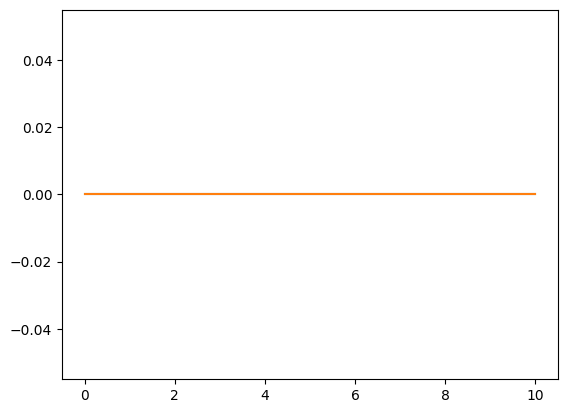

In [ ]:
y = tf.zeros(shape = (N,), dtype = 'float64')
y.numpy()[0] = f1(0)
yex = y
for i in range(N-1):
  y.numpy()[i+1] = y.numpy()[i] + dt*i*model(model(tf.constant([y.numpy()[i]], dtype =  'float64')))
  yex.numpy()[i+1] = f1(dt*(i+1))

t = np.linspace(start = 0, stop = 10, num = N)

plt.plot(t,y)
plt.plot(t,yex)

In [ ]:
y0 =  tf.constant([[random.gauss(1, 2.0)]], dtype = 'float64')
y = tf.constant(1, dtype = 'float64')
x = tf.constant(1, dtype  ='float64')
x = tf.constant([[x]], dtype  ='float64')

ValueError: ignored

#prova senza T


In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt
import os
import random
import MyDatasetGenerator as dg

tfk = tf.keras
tfkl = tf.keras.layers
tf.keras.backend.set_floatx('float64')


seed = 20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

initializers = tf.keras.initializers
init = initializers.GlorotNormal(seed = seed)
tf.keras.layers.experimental.preprocessing.Normalization(dtype='float64')
model = tfk.Sequential([
#   tfk.layers.Dense(2, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(2, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(5, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
    tfk.layers.Dense(32, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(20, activation='relu'),
    tfk.layers.Dense(1, activation='linear',kernel_initializer= init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Softmax()
])





In [ ]:
#learning_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [ ]:
N = 30
training_steps = 500
display_step = 1
def f1(x):
  return math.exp(-x)
summation = []
T = 10
dt = T/N
def loss1():
  y0 =  tf.constant([[f1(0)]], dtype = 'float64')
  for i in range(N-1):
    i = i + 1
    y = y0 + dt * model([[y0]])
    summation.append((f1(dt*i) - y))
    y0 = y
  return tf.reduce_mean(tf.abs(summation))

def train_step2():
  with tf.GradientTape() as tape:
    loss = loss1()
  gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return gradients


In [ ]:
#TRAINING LOOP
for i in range(training_steps):
  gradients = train_step2()
  if i % display_step == 0:
    print("iterazione numero: %i " %(i))
    print("loss: %f " % (loss1()))


iterazione numero: 0 
loss: 10.428216 
iterazione numero: 1 
loss: 10.351403 
iterazione numero: 2 
loss: 10.444293 
iterazione numero: 3 
loss: 10.313752 
iterazione numero: 4 
loss: 10.096167 
iterazione numero: 5 
loss: 9.855572 
iterazione numero: 6 
loss: 9.620382 
iterazione numero: 7 
loss: 9.403544 
iterazione numero: 8 
loss: 9.208409 
iterazione numero: 9 
loss: 9.032746 
iterazione numero: 10 
loss: 8.872068 
iterazione numero: 11 
loss: 8.721639 
iterazione numero: 12 
loss: 8.577388 
iterazione numero: 13 
loss: 8.436183 
iterazione numero: 14 
loss: 8.295818 
iterazione numero: 15 
loss: 8.154876 
iterazione numero: 16 
loss: 8.012572 
iterazione numero: 17 
loss: 7.868607 
iterazione numero: 18 
loss: 7.723033 
iterazione numero: 19 
loss: 7.576154 
iterazione numero: 20 
loss: 7.428437 
iterazione numero: 21 
loss: 7.280448 
iterazione numero: 22 
loss: 7.132794 
iterazione numero: 23 
loss: 6.986087 
iterazione numero: 24 
loss: 6.840909 
iterazione numero: 25 
loss: 6

In [ ]:
gradients
#model.trainable_variables

[<tf.Tensor: shape=(1, 32), dtype=float64, numpy=
 array([[ 2.59593822e-05,  3.91063864e-06,  2.45620526e-05,
         -1.58750670e-05,  1.69469389e-05, -1.85001357e-05,
         -2.27052405e-05, -2.40510867e-05,  1.07193754e-05,
          1.59165724e-05, -2.26458621e-05,  7.02808967e-06,
          1.09722418e-05, -1.48638076e-05,  2.51423840e-05,
          1.19029504e-05, -4.65073874e-05,  2.61771650e-05,
         -3.24340738e-05, -3.13403830e-05,  1.53578818e-05,
          1.62401128e-05, -3.57140620e-05,  1.46920889e-05,
         -7.76627011e-07, -3.33307882e-05,  5.81653884e-06,
         -3.86434834e-05,  1.43652546e-05,  3.53406327e-06,
          1.13214473e-05,  2.57208186e-05]])>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([-2.35052123e-05, -2.99531296e-06, -2.23951429e-05,  1.36743976e-05,
        -1.59227147e-05,  1.57128670e-05,  4.08163150e-07,  1.96595318e-05,
        -9.71451550e-06, -1.49647912e-05,  1.87164436e-05, -5.90580478e-06,
        -9.98063605e-06,  1

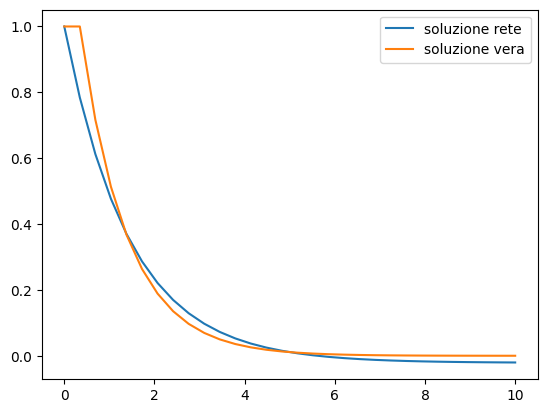

In [ ]:
#PLOT
y = np.zeros(N)
y[0]= f1(0)
yex = np.zeros(N)
yex[0]= f1(0)
curr_y = tf.constant([f1(0)], dtype = 'float64')
for i in range(N-1):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_y = curr_y + dt * model(curr_y)
    y[i+1] = next_y.numpy()[0][0]
    yex[i+1] = f1(dt*i)
    curr_y = next_y

t = np.linspace(start = 0, stop = 10, num = N)
plt.plot(t, y)
plt.plot(t, yex)
plt.legend(["soluzione rete", "soluzione vera"])

#Prova pinn


In [ ]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt
import os
import random
import MyDatasetGenerator as dg

tfk = tf.keras
tfkl = tf.keras.layers
tf.keras.backend.set_floatx('float64')


seed = 20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

initializers = tf.keras.initializers
init = initializers.GlorotNormal(seed = seed)
tf.keras.layers.experimental.preprocessing.Normalization(dtype='float64')
model = tfk.Sequential([
#   tfk.layers.Dense(2, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(2, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(5, activation='sigmoid', input_shape=(1,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
    tfk.layers.Dense(20, activation='sigmoid', input_shape=(2,), kernel_initializer=init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Dense(20, activation='relu'),
    tfk.layers.Dense(1, activation='linear',kernel_initializer= init, bias_initializer=initializers.Zeros()),
#   tfk.layers.Softmax()
])





In [ ]:
input = tf.Variable([[1,2]],dtype = 'float64')
#model(input)
with tf.GradientTape() as tape:
  input = tf.Variable([[1,2]],dtype = 'float64')
  tape.watch(input)
  beta = model(input)
grad = tape.gradient(beta,input)
print(grad)

tf.Tensor([[ 0.35865074 -0.01944718]], shape=(1, 2), dtype=float64)


In [ ]:
t = tf.Variable([[1]],dtype = 'float64')
T = tf.constant([[2]], dtype = 'float64' )
a = tf.concat([t,T],axis = -1)
model(a)
with tf.GradientTape() as tape:
  t = tf.Variable([[1]],dtype = 'float64')
  T = tf.constant([[2]], dtype = 'float64' )
  a = tf.concat([t,T],axis = -1)
  tape.watch(t)
  #tape.watch(T)
  beta = model(a)
grad = tape.gradient(beta,t)
print(grad)

tf.Tensor([[0.35865074]], shape=(1, 1), dtype=float64)


In [ ]:
#model.load_weights('ckptpinn')

In [ ]:
#learning_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
t_max = 1
tau = t_max
N = 20
training_steps = 500
display_step = 1
beta0 = np.array([0.5])
max = 1/2

def T(t):
  return math.cos(2*math.pi/t_max*(t-t_max*max))*14 + 16
Tmax = T(t_max*max)
def beta_eq(T):
  return 0.8 - 0.6/Tmax*T
def f(beta, T):
    return (beta_eq(T) - beta[0])/tau

data = {
    "N" : N,
    "t_max" : t_max,
    "beta0" : beta0,
    "f" : f
}
def fnew(beta, T):
    return (beta_eq(T) - beta)/tau

dataset = dg.generate_dataset([T], data)


#def f1(x):
 # return math.exp(-x)
summation = []
dt = t_max/N
def lossPINN():
  #y0 =  tf.constant([[dataset[0][0][0]]], dtype = 'float64')
  for i in range(N-1):
    with tf.GradientTape() as tape:
      t = tf.Variable([[dt*i]],dtype = 'float64')
      Temp = tf.constant([[T(t)]],dtype = 'float64')
      input = tf.concat([t,Temp],axis = -1)
      tape.watch(t)
      betatilde = model(input)
    betatildedot = tape.gradient(betatilde, t)
    #i = i + 1
    #y = y0 + dt * model([[y0]])
    beta = dataset[1][0][i]
    summation.append((beta - betatilde)**2 + (betatildedot - fnew(betatilde,T(t)))**2)
    #y0 = y
  return tf.reduce_mean(tf.abs(summation))

def train_stepPINN():
  with tf.GradientTape() as tape:
    loss = lossPINN()
  gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return gradients

In [ ]:
with tf.GradientTape() as tape:
  t = tf.Variable([[dt*5]],dtype = 'float64')
  Temp = tf.constant([[T(t)]],dtype = 'float64')
  input = tf.concat([t,Temp],axis = -1)
  tape.watch(t)
  betatilde = model(input)
betatildedot = tape.gradient(betatilde, t)
beta = dataset[1][0][5]
((beta - betatilde)**2 + (betatildedot - fnew(betatilde,T(t)))**2)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.011303]])>

In [ ]:
#TRAINING LOOP
for i in range(training_steps):
  gradients = train_stepPINN()
  if i % display_step == 0:
    print("iterazione numero: %i " %(i))
    print("loss: %f " % (lossPINN()))


iterazione numero: 0 
loss: 0.202452 
iterazione numero: 1 
loss: 0.201427 
iterazione numero: 2 
loss: 0.200409 
iterazione numero: 3 
loss: 0.199394 
iterazione numero: 4 
loss: 0.198387 
iterazione numero: 5 
loss: 0.197386 
iterazione numero: 6 
loss: 0.196390 
iterazione numero: 7 
loss: 0.195401 
iterazione numero: 8 
loss: 0.194421 
iterazione numero: 9 
loss: 0.193445 
iterazione numero: 10 
loss: 0.192476 
iterazione numero: 11 
loss: 0.191516 
iterazione numero: 12 
loss: 0.190562 
iterazione numero: 13 
loss: 0.189615 
iterazione numero: 14 
loss: 0.188674 
iterazione numero: 15 
loss: 0.187740 
iterazione numero: 16 
loss: 0.186814 
iterazione numero: 17 
loss: 0.185894 
iterazione numero: 18 
loss: 0.184982 
iterazione numero: 19 
loss: 0.184078 
iterazione numero: 20 
loss: 0.183183 
iterazione numero: 21 
loss: 0.182295 
iterazione numero: 22 
loss: 0.181416 
iterazione numero: 23 
loss: 0.180544 
iterazione numero: 24 
loss: 0.179681 
iterazione numero: 25 
loss: 0.1788

In [ ]:
gradients
#model.trainable_variables

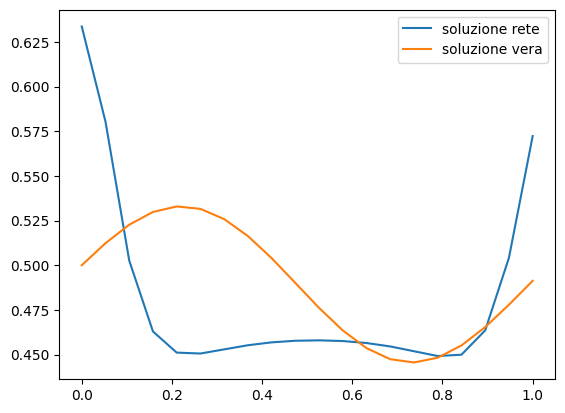

In [ ]:
#PLOT
y = np.zeros(N)
yex = np.zeros(N)
#curr_y = tf.constant([beta0], dtype = 'float64')
for i in range(N):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
#    next_y = curr_y + dt * model(curr_y)
    t = tf.Variable([[dt*i]],dtype = 'float64')
    Temp = tf.constant([[T(t)]],dtype = 'float64')
    input = tf.concat([t,Temp],axis = -1)
    y[i] = model(input).numpy()[0][0]
    yex[i] = dataset[1,0,i]
    #curr_y = next_y

t = np.linspace(start = 0, stop = t_max, num = N)
plt.plot(t, y)
plt.plot(t, yex)
plt.legend(["soluzione rete", "soluzione vera"])

In [ ]:
model.save_weights('ckptpinn')